# Packages

In [1]:
# Use autoreload to automatically reload modules
%load_ext autoreload
%autoreload 2

import rootutils
root_path = rootutils.find_root()

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import rootutils
from sklearn.metrics.pairwise import cosine_similarity

from burned_embedder import utils
from burned_embedder.analysis import analyze_fire_detection, compare_modes
from burned_embedder.data import find_closest_timestamps, load_s1, load_s2
from burned_embedder.model import load_model, process_embeddings_batched
from burned_embedder.plot import create_summary_visualization

# Variables

In [3]:
# Setup
plt.style.use('seaborn-v0_8')
device = utils.setup_device(gpu_index=1, memory_fraction=1.0)
print(f"Using device: {device}")

# Create output directories
figures_dir = root_path / "reports" / "figures" / "dueben_fire"
figures_dir.mkdir(parents=True, exist_ok=True)

# Constants
LON = 13.32200476
LAT = 51.4222985
FIRE_DATE = datetime(2025, 7, 3)
EDGE_SIZE = 128
RESOLUTION = 10
KERNEL_SIZE = 16
AREA = (16 * 10 / 1000) ** 2  # Surface area of one patch in km²


# Spectral parameters
S2_WAVELENGTHS = [440, 490, 560, 665, 705, 740, 783, 842, 860, 940, 1610, 2190]
S2_BANDWIDTHS = [20, 65, 35, 30, 15, 15, 20, 115, 20, 20, 90, 180]
S1_WAVELENGTHS = [5e7, 5e7]  
S1_BANDWIDTHS = [1e9, 1e9]

Using device: cuda:1


# Data

## Retrieving

In [4]:
# Load data
da_s1 = load_s1(LAT, LON, start_date="2017-01-01", end_date="2025-12-31")
da_s2 = load_s2(LAT, LON, start_date="2017-01-01", end_date="2025-12-31")

Loading Sentinel-1 data...
S1 data shape: (1834, 2, 128, 128)
Loading Sentinel-2 data...
Applying baseline harmonization to bands: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
S2 data shape: (111, 12, 128, 128)


## Merge Data

In [5]:
# Find matching timestamps
timestamp_pairs = find_closest_timestamps(da_s1.time.values, da_s2.time.values, max_diff_days=2)
print(f"Found {len(timestamp_pairs)} matching S1-S2 pairs")

Found 111 matching S1-S2 pairs


## Visualize data

In [6]:
def img_interactive(da):

    import ipywidgets as widgets
    import matplotlib.pyplot as plt

    def plot_time_step(time_index):
        plt.figure(figsize=(8, 8))
        da.isel(time=time_index).plot.imshow(robust=True)
        plt.title(f"{str(da.time.values[time_index])[:10]}")
        plt.axis('off')
        plt.show()

    widgets.interact(plot_time_step, time_index=widgets.IntSlider(min=0, max=len(da.time)-1, step=1, value=0))


da_s2_rgb = da_s2.sel(band=["B04", "B03", "B02"])

img_interactive(da_s2_rgb)


interactive(children=(IntSlider(value=0, description='time_index', max=110), Output()), _dom_classes=('widget-…

# Model

## Load

In [ ]:
# Load model
encoder = load_model(device)
# Process embeddings for each mode
modes = ['s1_only', 's2_only', 'combined']
results = {}

Loading Copernicus FM model...


CopernicusFM(
  (fc_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (patch_embed_spectral): DynamicPatchEmbed(
    (spectrum_central_expansion): FourierExpansion()
    (spectrum_bandwidth_expansion): FourierExpansion()
    (weight_generator): TransformerWeightGenerator(
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=2048, bias=True)
            (dropout): Dropout(p=False, inplace=False)
            (linear2): Linear(in_features=2048, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=False, inplace=False)
            (drop

## Metadata Setup

In [42]:
# Spectral response for Sentinel-2 (all 13 bands) - from paper
s2_wavelengths = [440, 490, 560, 665, 705, 740, 783, 842, 860, 940, 1610, 2190]
s2_bandwidths = [20, 65, 35, 30, 15, 15, 20, 115, 20, 20, 90, 180]

# Spectral response for Sentinel-1 (SAR) 
s1_wavelengths = [5e7, 5e7]  
s1_bandwidths = [1e9, 1e9]

# Combined parameters (S1 first, then S2)
combined_wavelengths = s1_wavelengths + s2_wavelengths  # 2 + 13 = 15 bands total
combined_bandwidths = s1_bandwidths + s2_bandwidths

# Processing parameters
kernel_size = 16
area = (16 * 10 / 1000) ** 2  # Surface area of one patch in km²


## Run Model

In [43]:
def process_combined_timestep(da_s1_t, da_s2_t):
    """Process combined S1+S2 data through Copernicus FM"""
    # Handle S1 data access issue - force load the data
    s1_data = np.array(da_s1_t)  # Shape: (2, H, W)
    s2_data = da_s2_t.values     # Shape: (12, H, W) - only 12 bands, not 13
    
    # Concatenate S1 and S2 along channel dimension
    combined_data = np.concatenate([s1_data, s2_data], axis=0)  # Shape: (14, H, W)
    
    # Convert to tensor
    x = torch.from_numpy(combined_data).float().unsqueeze(0)
    x = x.to(device)
    
    # Create metadata
    lon_tensor = torch.tensor(lon).float()
    lat_tensor = torch.tensor(lat).float()
    time_tensor = torch.tensor(float('nan'))
    area_tensor = torch.tensor(area).float()
    meta_data = torch.stack((lon_tensor, lat_tensor, time_tensor, area_tensor), dim=-1).unsqueeze(0).to(device)
    
    # Adjust wavelengths/bandwidths for 14 bands (2 S1 + 12 S2)
    combined_wavelengths_14 = s1_wavelengths + s2_wavelengths[:12]  # Only first 12 S2 bands
    combined_bandwidths_14 = s1_bandwidths + s2_bandwidths[:12]
    
    # Get embedding
    with torch.no_grad():
        embedding = encoder(x, meta_data, combined_wavelengths_14, combined_bandwidths_14, 
                          language_embed=None, input_mode='spectral', kernel_size=kernel_size)
    
    return embedding.cpu().numpy().flatten()


In [44]:
def calculate_ndvi(da_s2_t):
    """Calculate NDVI from Sentinel-2 data"""
    nir = da_s2_t.sel(band='B08').values  # Near-infrared
    red = da_s2_t.sel(band='B04').values  # Red
    ndvi = (nir - red) / (nir + red + 1e-8)
    return np.nanmean(ndvi)


In [45]:
# Process all matching timesteps
print(f"Processing {len(timestamp_pairs)} combined S1+S2 timesteps...")

embeddings_list = []
ndvi_list = []
dates_list = []

for s2_idx, s1_idx in tqdm(timestamp_pairs):
    da_s2_t = da_s2_unique.isel(time=s2_idx)
    da_s1_t = da_s1_unique.isel(time=s1_idx)
    
    # Get combined embedding
    embedding = process_combined_timestep(da_s1_t, da_s2_t)
    embeddings_list.append(embedding)
    
    # Calculate NDVI from S2 data
    ndvi = calculate_ndvi(da_s2_t)
    ndvi_list.append(ndvi)
    
    # Use S2 date as reference
    dates_list.append(da_s2_unique.time.values[s2_idx])

# Convert to arrays
embeddings_array = np.vstack(embeddings_list)
ndvi_array = np.array(ndvi_list)
dates_array = np.array(dates_list)


Processing 57 combined S1+S2 timesteps...


  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 57/57 [00:57<00:00,  1.00s/it]


In [46]:
print(f"Combined S1+S2 embeddings shape: {embeddings_array.shape}")

Combined S1+S2 embeddings shape: (57, 768)


# Analysis

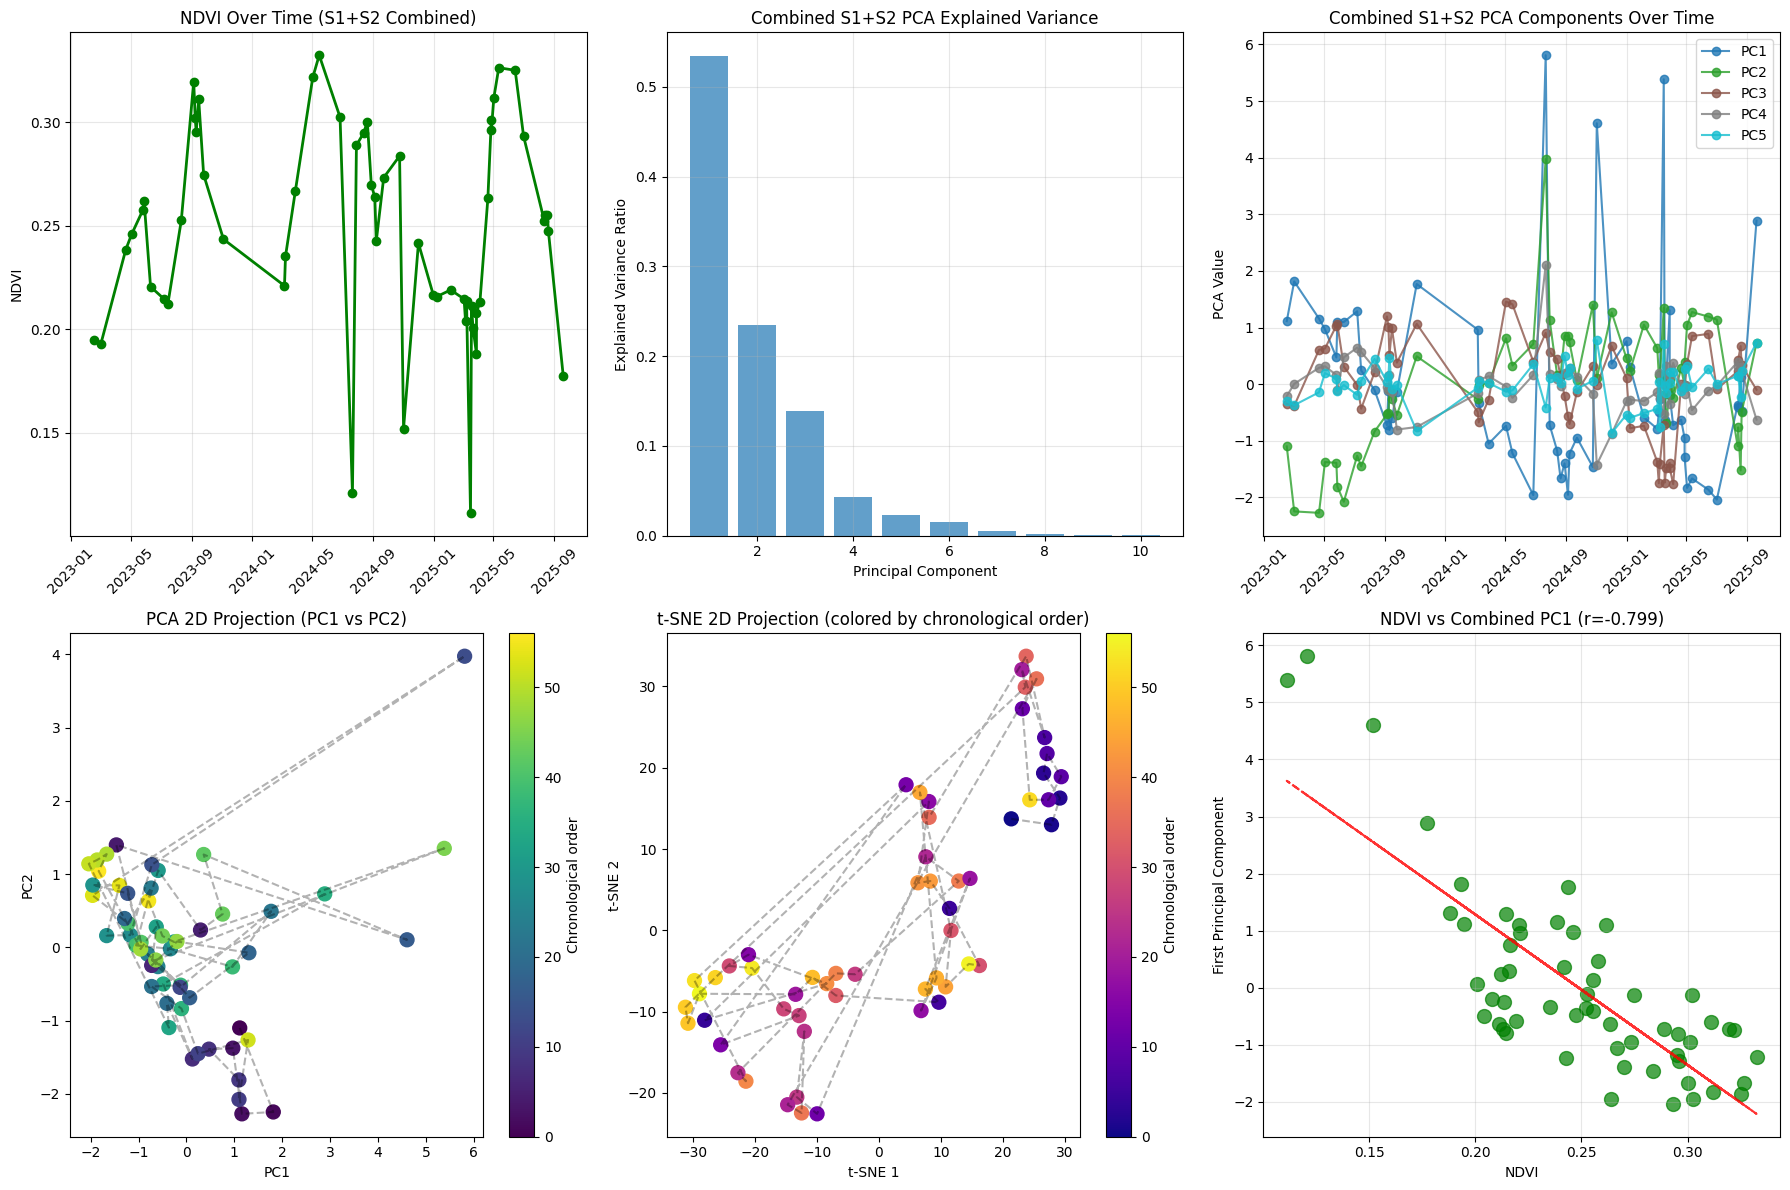


NDVI Statistics:
Mean: 0.249
Std: 0.050
Min: 0.111
Max: 0.332

PCA Explained Variance (first 5 components): [0.5340613  0.23418406 0.13896617 0.04277018 0.02357984]
Total variance explained by first 5 components: 0.974

NDVI vs Combined PC1 correlation: -0.799


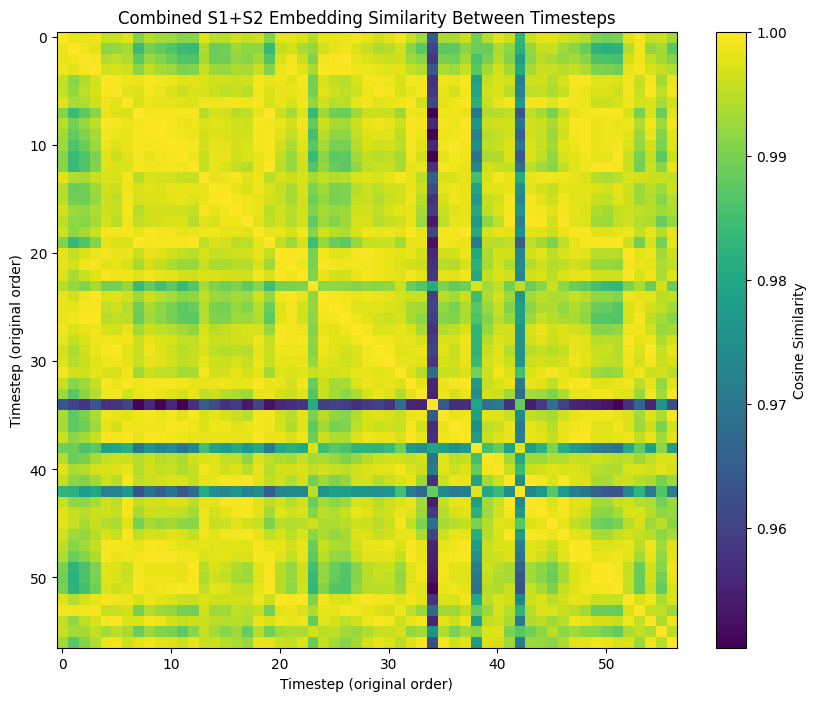


Processing complete! The model now uses combined S1+S2 data with 14 total bands.


In [ ]:
# Apply dimensionality reduction
pca = PCA(n_components=min(10, len(dates_list)-1))
embeddings_pca = pca.fit_transform(embeddings_array)

# Try UMAP if available
try:
    from umap import UMAP
    umap_reducer = UMAP(n_components=2, random_state=42)
    embeddings_umap = umap_reducer.fit_transform(embeddings_array)
    has_umap = True
except ImportError:
    has_umap = False

# t-SNE
if len(embeddings_array) > 5:
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(dates_list)-1))
    embeddings_tsne = tsne.fit_transform(embeddings_array)
    has_tsne = True
else:
    has_tsne = False

# Sort all data by dates to fix zigzag line plots
sort_indices = np.argsort(dates_array)
dates_sorted = dates_array[sort_indices]
embeddings_sorted = embeddings_array[sort_indices]
ndvi_sorted = ndvi_array[sort_indices]
embeddings_pca_sorted = embeddings_pca[sort_indices]
if has_umap:
    embeddings_umap_sorted = embeddings_umap[sort_indices]
if has_tsne:
    embeddings_tsne_sorted = embeddings_tsne[sort_indices]

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: NDVI timeseries (sorted)
axes[0, 0].plot(dates_sorted, ndvi_sorted, 'g-o', linewidth=2, markersize=6)
axes[0, 0].set_title('NDVI Over Time (S1+S2 Combined)')
axes[0, 0].set_ylabel('NDVI')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: PCA explained variance
axes[0, 1].bar(range(1, len(pca.explained_variance_ratio_)+1), 
               pca.explained_variance_ratio_, alpha=0.7)
axes[0, 1].set_title('Combined S1+S2 PCA Explained Variance')
axes[0, 1].set_xlabel('Principal Component')
axes[0, 1].set_ylabel('Explained Variance Ratio')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: PCA components over time (sorted)
colors = plt.cm.tab10(np.linspace(0, 1, min(5, embeddings_pca_sorted.shape[1])))
for i in range(min(5, embeddings_pca_sorted.shape[1])):
    axes[0, 2].plot(dates_sorted, embeddings_pca_sorted[:, i], '-o', 
                    color=colors[i], label=f'PC{i+1}', alpha=0.8)
axes[0, 2].set_title('Combined S1+S2 PCA Components Over Time')
axes[0, 2].set_ylabel('PCA Value')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot 4: UMAP or PCA 2D projection
if has_umap:
    scatter = axes[1, 0].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                               c=sort_indices, cmap='viridis', s=100)
    axes[1, 0].set_title('UMAP 2D Projection (colored by chronological order)')
    axes[1, 0].set_xlabel('UMAP 1')
    axes[1, 0].set_ylabel('UMAP 2')
    plt.colorbar(scatter, ax=axes[1, 0], label='Chronological order')
    # Plot trajectory in chronological order
    axes[1, 0].plot(embeddings_umap_sorted[:, 0], embeddings_umap_sorted[:, 1], 'k--', alpha=0.3)
else:
    scatter = axes[1, 0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                               c=sort_indices, cmap='viridis', s=100)
    axes[1, 0].set_title('PCA 2D Projection (PC1 vs PC2)')
    axes[1, 0].set_xlabel('PC1')
    axes[1, 0].set_ylabel('PC2')
    plt.colorbar(scatter, ax=axes[1, 0], label='Chronological order')
    # Plot trajectory in chronological order
    axes[1, 0].plot(embeddings_pca_sorted[:, 0], embeddings_pca_sorted[:, 1], 'k--', alpha=0.3)

# Plot 5: t-SNE or alternative
if has_tsne:
    scatter2 = axes[1, 1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                                c=sort_indices, cmap='plasma', s=100)
    axes[1, 1].set_title('t-SNE 2D Projection (colored by chronological order)')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    plt.colorbar(scatter2, ax=axes[1, 1], label='Chronological order')
    # Plot trajectory in chronological order
    axes[1, 1].plot(embeddings_tsne_sorted[:, 0], embeddings_tsne_sorted[:, 1], 'k--', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Not enough data\nfor t-SNE', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('t-SNE (insufficient data)')

# Plot 6: Correlation between NDVI and first PCA component
if len(ndvi_array) > 1:
    axes[1, 2].scatter(ndvi_array, embeddings_pca[:, 0], alpha=0.7, s=100, color='green')
    correlation = np.corrcoef(ndvi_array, embeddings_pca[:, 0])[0, 1]
    axes[1, 2].set_title(f'NDVI vs Combined PC1 (r={correlation:.3f})')
    axes[1, 2].set_xlabel('NDVI')
    axes[1, 2].set_ylabel('First Principal Component')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(ndvi_array, embeddings_pca[:, 0], 1)
    p = np.poly1d(z)
    axes[1, 2].plot(ndvi_array, p(ndvi_array), "r--", alpha=0.8)
else:
    axes[1, 2].text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                    ha='center', va='center', transform=axes[1, 2].transAxes)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nNDVI Statistics:")
print(f"Mean: {np.mean(ndvi_array):.3f}")
print(f"Std: {np.std(ndvi_array):.3f}")
print(f"Min: {np.min(ndvi_array):.3f}")
print(f"Max: {np.max(ndvi_array):.3f}")

print(f"\nPCA Explained Variance (first 5 components): {pca.explained_variance_ratio_[:5]}")
print(f"Total variance explained by first 5 components: {np.sum(pca.explained_variance_ratio_[:5]):.3f}")

if len(ndvi_array) > 1:
    print(f"\nNDVI vs Combined PC1 correlation: {correlation:.3f}")

# Embedding similarity analysis (using original order for similarity matrix)
if len(embeddings_array) > 1:
    similarity_matrix = cosine_similarity(embeddings_array)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Combined S1+S2 Embedding Similarity Between Timesteps')
    plt.xlabel('Timestep (original order)')
    plt.ylabel('Timestep (original order)')
    plt.show()

print("\nProcessing complete! The model now uses combined S1+S2 data with 14 total bands.")

Performing PCA analysis...


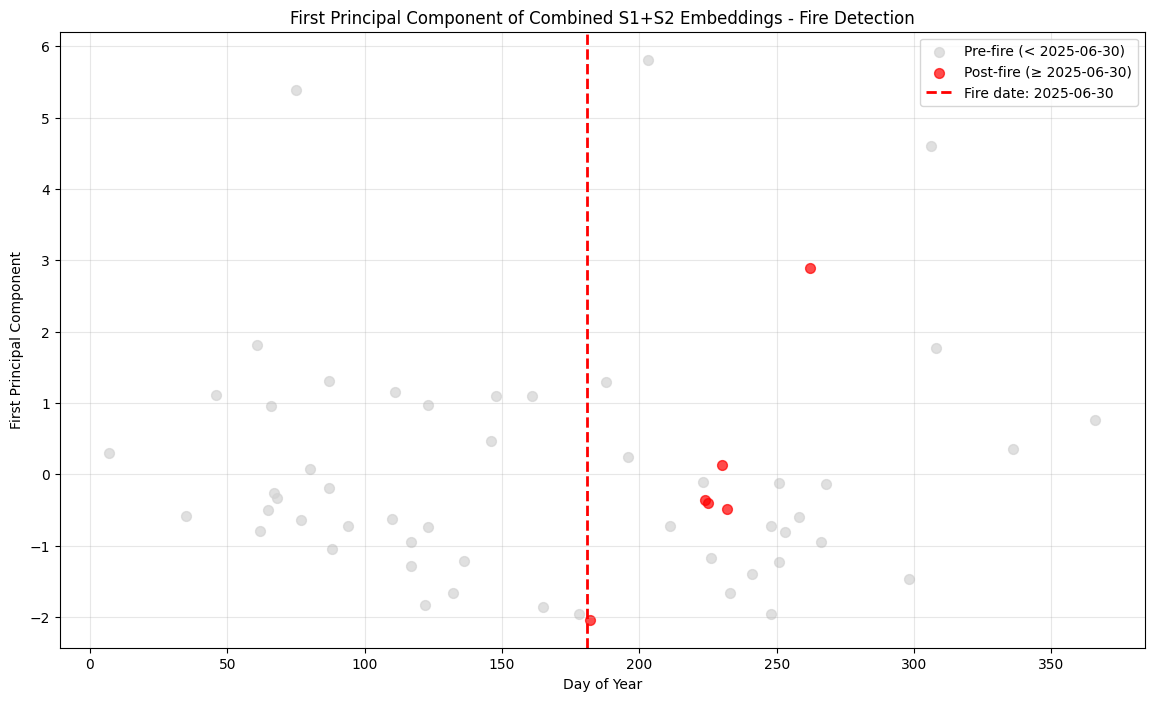

Creating t-SNE visualization...


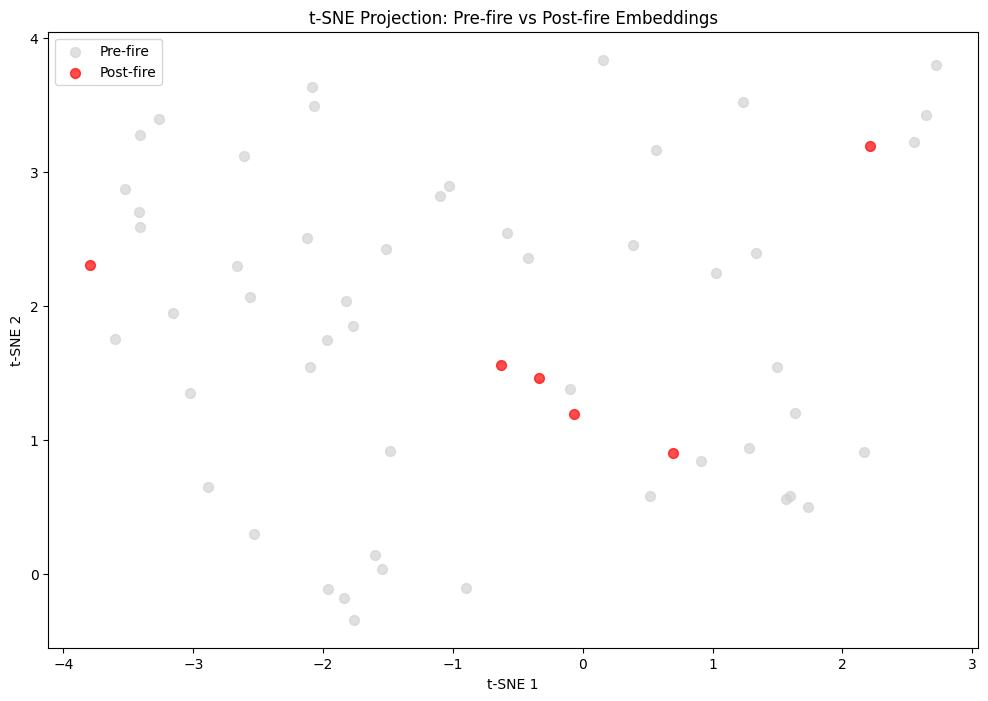

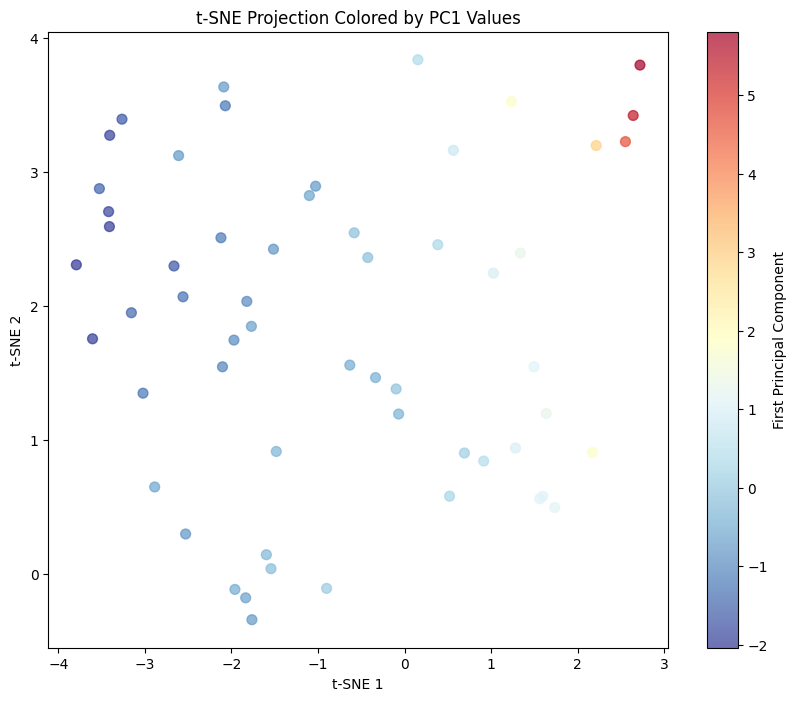

Pre-fire data points: 51
Post-fire data points: 6


/tmp/ipykernel_3600926/2013922398.py:91: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(seasonal_curve, pre_fire_days, pre_fire_pc1)


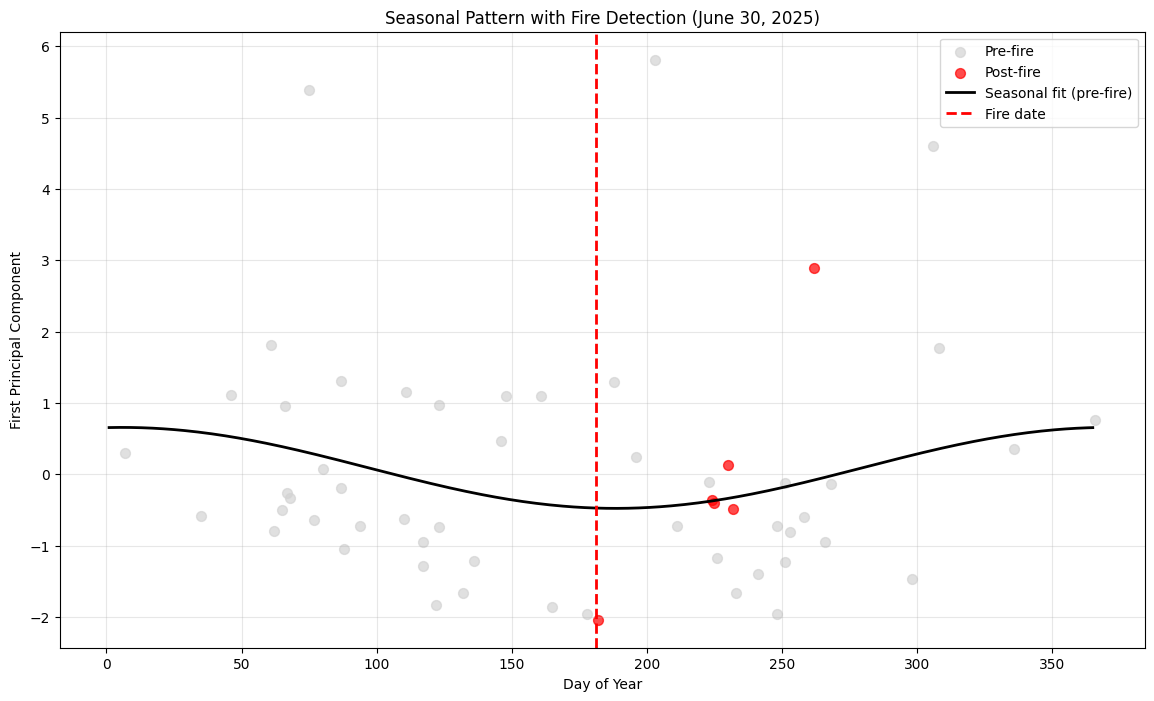

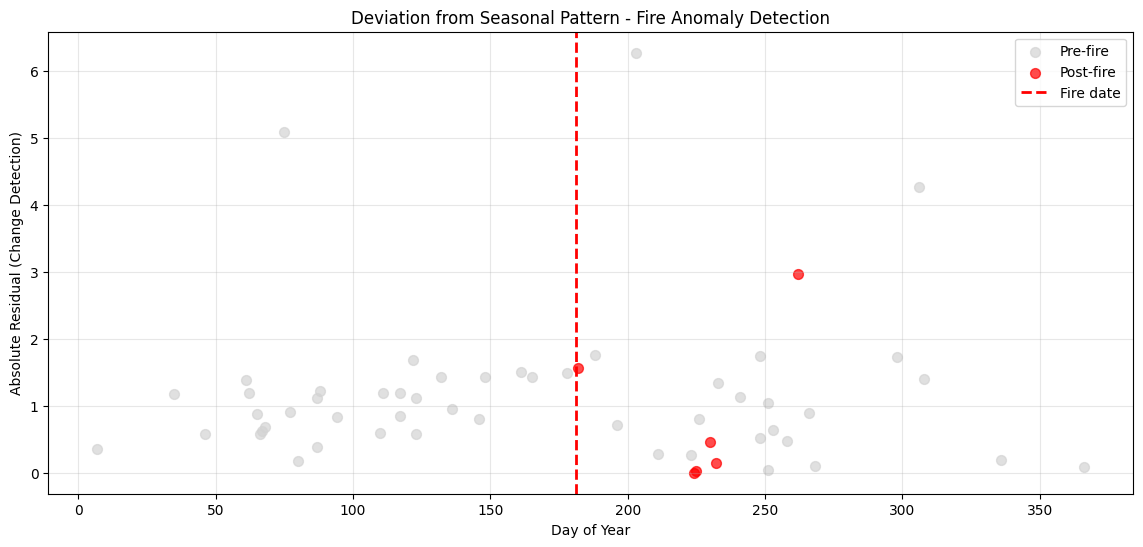

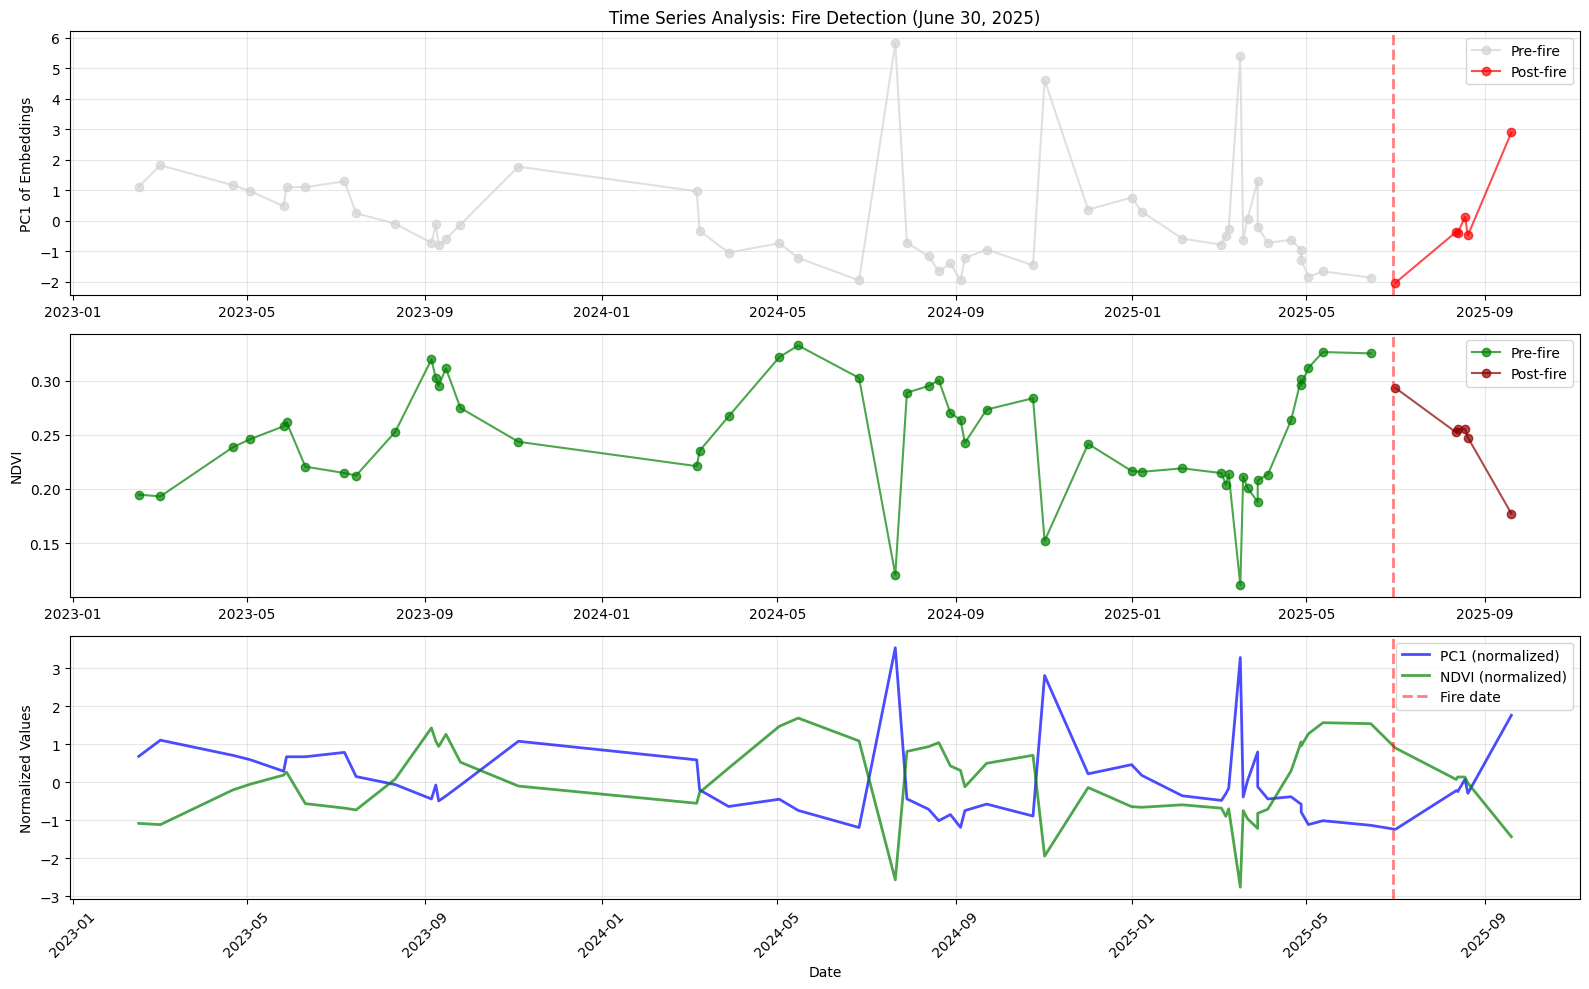


=== FIRE DETECTION ANALYSIS SUMMARY ===
Fire date: 2025-06-30 (Day 181)
Total timesteps analyzed: 57
Pre-fire timesteps: 51
Post-fire timesteps: 6
Embedding dimension: 768
Date range: 2023-02-15T10:21:21.024000000 to 2025-09-19T10:10:41.025000000
PC1 variance explained: 0.534

PRE-FIRE vs POST-FIRE COMPARISON:
PC1 mean - Pre: 0.005, Post: -0.047
PC1 std - Pre: 1.658, Post: 1.474
NDVI mean - Pre: 0.249, Post: 0.247
NDVI std - Pre: 0.051, Post: 0.035
PC1 t-test p-value: 0.9426
NDVI t-test p-value: 0.9255

ANOMALY DETECTION:
Anomaly threshold (2σ): 3.390
Potential fire-affected timesteps: 3
Anomaly dates: ['2024-07-21', '2024-11-01', '2025-03-16']


In [59]:
# Add these additional imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Skip UMAP for now, we'll use t-SNE instead
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
from datetime import datetime
import pandas as pd

# 1. PCA Analysis - Extract first principal component
print("Performing PCA analysis...")
pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(embeddings_array)

# Extract dates as day of year for plotting
dates_datetime = [pd.to_datetime(date) for date in dates_array]
day_of_year = [date.timetuple().tm_yday for date in dates_datetime]
years = [date.year for date in dates_datetime]

# Fire occurred on June 30, 2025 (day 181)
fire_date = datetime(2025, 6, 30)
fire_day_of_year = fire_date.timetuple().tm_yday  # Day 181

# Create color coding: pre-fire vs post-fire
colors = ['red' if date >= fire_date else 'lightgray' for date in dates_datetime]

# Plot first principal component over time
plt.figure(figsize=(14, 8))
for color, label in zip(['lightgray', 'red'], ['Pre-fire (< 2025-06-30)', 'Post-fire (≥ 2025-06-30)']):
    mask = [c == color for c in colors]
    if any(mask):
        plt.scatter(np.array(day_of_year)[mask], embeddings_pca[mask, 0], 
                   c=color, alpha=0.7, s=50, label=label)

# Mark fire date
plt.axvline(x=fire_day_of_year, color='red', linestyle='--', linewidth=2, 
           label=f'Fire date: {fire_date.strftime("%Y-%m-%d")}')

plt.xlabel('Day of Year')
plt.ylabel('First Principal Component')
plt.title('First Principal Component of Combined S1+S2 Embeddings - Fire Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. t-SNE Visualization (instead of UMAP)
print("Creating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_array)-1))
embeddings_tsne = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(12, 8))
for color, label in zip(['lightgray', 'red'], ['Pre-fire', 'Post-fire']):
    mask = [c == color for c in colors]
    if any(mask):
        plt.scatter(embeddings_tsne[mask, 0], embeddings_tsne[mask, 1], 
                   c=color, alpha=0.7, s=50, label=label)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection: Pre-fire vs Post-fire Embeddings')
plt.legend()
plt.show()

# Alternative: Color by PC1 values
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                     c=embeddings_pca[:, 0], cmap='RdYlBu_r', alpha=0.7, s=50)
plt.colorbar(scatter, label='First Principal Component')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection Colored by PC1 Values')
plt.show()

# 3. Seasonal Analysis with Regression Curve
def seasonal_curve(day, a, b, c, d):
    """Sinusoidal function to model seasonal variation"""
    return a * np.sin(2 * np.pi * day / 365 + b) + c

# Fit seasonal curve to pre-fire data only
pre_fire_mask = [date < fire_date for date in dates_datetime]
pre_fire_days = np.array(day_of_year)[pre_fire_mask]
pre_fire_pc1 = embeddings_pca[pre_fire_mask, 0]

print(f"Pre-fire data points: {len(pre_fire_pc1)}")
print(f"Post-fire data points: {len(embeddings_pca) - len(pre_fire_pc1)}")

if len(pre_fire_pc1) > 4:  # Need enough points to fit
    try:
        popt, _ = curve_fit(seasonal_curve, pre_fire_days, pre_fire_pc1)
        
        # Calculate residuals for all points
        all_days = np.array(day_of_year)
        predicted = seasonal_curve(all_days, *popt)
        residuals = embeddings_pca[:, 0] - predicted
        
        plt.figure(figsize=(14, 8))
        
        # Plot actual data points
        for color, label in zip(['lightgray', 'red'], ['Pre-fire', 'Post-fire']):
            mask = [c == color for c in colors]
            if any(mask):
                plt.scatter(np.array(day_of_year)[mask], embeddings_pca[mask, 0], 
                           c=color, alpha=0.7, s=50, label=label)
        
        # Plot fitted curve
        x_smooth = np.linspace(1, 365, 365)
        y_smooth = seasonal_curve(x_smooth, *popt)
        plt.plot(x_smooth, y_smooth, 'k-', linewidth=2, label='Seasonal fit (pre-fire)')
        
        # Mark fire date
        plt.axvline(x=fire_day_of_year, color='red', linestyle='--', linewidth=2, 
                   label='Fire date')
        
        plt.xlabel('Day of Year')
        plt.ylabel('First Principal Component')
        plt.title('Seasonal Pattern with Fire Detection (June 30, 2025)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Plot residuals to highlight anomalies
        plt.figure(figsize=(14, 6))
        for color, label in zip(['lightgray', 'red'], ['Pre-fire', 'Post-fire']):
            mask = [c == color for c in colors]
            if any(mask):
                plt.scatter(np.array(day_of_year)[mask], np.abs(residuals)[mask], 
                           c=color, alpha=0.7, s=50, label=label)
        
        plt.axvline(x=fire_day_of_year, color='red', linestyle='--', linewidth=2, 
                   label='Fire date')
        plt.xlabel('Day of Year')
        plt.ylabel('Absolute Residual (Change Detection)')
        plt.title('Deviation from Seasonal Pattern - Fire Anomaly Detection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        print(f"Could not fit seasonal curve: {e}")

# 4. Time Series Analysis
# Sort data by date for proper time series plotting
sorted_indices = np.argsort(dates_array)
sorted_dates = dates_array[sorted_indices]
sorted_embeddings_pc1 = embeddings_pca[sorted_indices, 0]
sorted_ndvi = ndvi_array[sorted_indices]
sorted_dates_dt = [pd.to_datetime(date) for date in sorted_dates]

plt.figure(figsize=(16, 10))

# Plot PC1 over time
plt.subplot(3, 1, 1)
pre_fire_indices = [i for i, date in enumerate(sorted_dates_dt) if date < fire_date]
post_fire_indices = [i for i, date in enumerate(sorted_dates_dt) if date >= fire_date]

if pre_fire_indices:
    plt.plot(np.array(sorted_dates_dt)[pre_fire_indices], 
             sorted_embeddings_pc1[pre_fire_indices], 'o-', color='lightgray', 
             alpha=0.7, label='Pre-fire')
if post_fire_indices:
    plt.plot(np.array(sorted_dates_dt)[post_fire_indices], 
             sorted_embeddings_pc1[post_fire_indices], 'o-', color='red', 
             alpha=0.7, label='Post-fire')

plt.axvline(x=fire_date, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('PC1 of Embeddings')
plt.title('Time Series Analysis: Fire Detection (June 30, 2025)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot NDVI over time
plt.subplot(3, 1, 2)
if pre_fire_indices:
    plt.plot(np.array(sorted_dates_dt)[pre_fire_indices], 
             sorted_ndvi[pre_fire_indices], 'o-', color='green', 
             alpha=0.7, label='Pre-fire')
if post_fire_indices:
    plt.plot(np.array(sorted_dates_dt)[post_fire_indices], 
             sorted_ndvi[post_fire_indices], 'o-', color='darkred', 
             alpha=0.7, label='Post-fire')

plt.axvline(x=fire_date, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('NDVI')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together (normalized)
plt.subplot(3, 1, 3)
# Normalize both series
pc1_norm = (sorted_embeddings_pc1 - np.mean(sorted_embeddings_pc1)) / np.std(sorted_embeddings_pc1)
ndvi_norm = (sorted_ndvi - np.mean(sorted_ndvi)) / np.std(sorted_ndvi)

plt.plot(sorted_dates_dt, pc1_norm, '-', color='blue', label='PC1 (normalized)', alpha=0.7, linewidth=2)
plt.plot(sorted_dates_dt, ndvi_norm, '-', color='green', label='NDVI (normalized)', alpha=0.7, linewidth=2)
plt.axvline(x=fire_date, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Fire date')

plt.ylabel('Normalized Values')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 5. Summary Statistics
print("\n=== FIRE DETECTION ANALYSIS SUMMARY ===")
print(f"Fire date: {fire_date.strftime('%Y-%m-%d')} (Day {fire_day_of_year})")
print(f"Total timesteps analyzed: {len(embeddings_array)}")
print(f"Pre-fire timesteps: {sum(pre_fire_mask)}")
print(f"Post-fire timesteps: {len(embeddings_array) - sum(pre_fire_mask)}")
print(f"Embedding dimension: {embeddings_array.shape[1]}")
print(f"Date range: {sorted_dates[0]} to {sorted_dates[-1]}")
print(f"PC1 variance explained: {pca.explained_variance_ratio_[0]:.3f}")

# Compare pre-fire vs post-fire statistics
pre_fire_pc1 = embeddings_pca[pre_fire_mask, 0]
post_fire_pc1 = embeddings_pca[[not x for x in pre_fire_mask], 0]
pre_fire_ndvi = ndvi_array[pre_fire_mask]
post_fire_ndvi = ndvi_array[[not x for x in pre_fire_mask]]

if len(pre_fire_pc1) > 0 and len(post_fire_pc1) > 0:
    print(f"\nPRE-FIRE vs POST-FIRE COMPARISON:")
    print(f"PC1 mean - Pre: {np.mean(pre_fire_pc1):.3f}, Post: {np.mean(post_fire_pc1):.3f}")
    print(f"PC1 std - Pre: {np.std(pre_fire_pc1):.3f}, Post: {np.std(post_fire_pc1):.3f}")
    print(f"NDVI mean - Pre: {np.mean(pre_fire_ndvi):.3f}, Post: {np.mean(post_fire_ndvi):.3f}")
    print(f"NDVI std - Pre: {np.std(pre_fire_ndvi):.3f}, Post: {np.std(post_fire_ndvi):.3f}")
    
    # Statistical test for difference
    from scipy.stats import ttest_ind
    pc1_ttest = ttest_ind(pre_fire_pc1, post_fire_pc1)
    ndvi_ttest = ttest_ind(pre_fire_ndvi, post_fire_ndvi)
    print(f"PC1 t-test p-value: {pc1_ttest.pvalue:.4f}")
    print(f"NDVI t-test p-value: {ndvi_ttest.pvalue:.4f}")

# Detect potential fire-affected timesteps based on PC1 anomalies
if 'residuals' in locals():
    threshold = np.mean(np.abs(residuals)) + 2 * np.std(np.abs(residuals))
    anomaly_mask = np.abs(residuals) > threshold
    print(f"\nANOMALY DETECTION:")
    print(f"Anomaly threshold (2σ): {threshold:.3f}")
    print(f"Potential fire-affected timesteps: {np.sum(anomaly_mask)}")
    if np.sum(anomaly_mask) > 0:
        anomaly_dates = dates_array[anomaly_mask]
        print("Anomaly dates:", [str(date)[:10] for date in anomaly_dates])